<h1> Bitcoin Time Series Modelling</h1>

The purpose of this project is to explore the application of the library Phophet on Bitcoins price action (from CryptoWatch API), to gain familiarity with the library and to create useful functions for both retriving cryptocurrency data, and evaluating prophet models.

<h3> Key Outcomes</h3>
<ul>
<li>Built foundational methodology of using Prophet for additive time series analysis  </li>
<li>Created a function to call cryptocurrnecy price data at specified granularity using CryptoWatch API </li>
<li>Created a function to find rolling pearsons correlation coefficient of two time series' over specified timeframe  </li>
<li>Evaluted Prophet change point relevancy to google trends interest </li>
<li>Created a function to compare different Prophet models via changepoint_prior_scale hyperparameter tuning </li>
<li>Bitcoin Prophet Hyperparameter Tuning </li>
    
    
</ul>

<h3> Contents </h3>
<ul>
<li>Bitcoin Price Action Retrieval from CryptoWatch API </li>
<li>Exploratory Rolling Pearson's Correlation Analysis With Index Funds </li>
<li>Bitcoin Prophet Introduction </li>
<li>Bitcoin Prophet Hyperparameter Tuning </li>
<li>Change Point Comparison with Google Trend Data  </li>
<li>Evaluating Prophet Model Predictions of Index Fund Prices  </li>

</ul>

<h2> Bitcoin Price Action Retrival from CryptoWatch API </h2>

In [8]:
import cryptowatch as cw
import pandas as pd 
import matplotlib.pyplot as plt
print("All libraries imported successfully")

#set api key
cw.api_key = 'QSIYN3W065D5BWUA7AFR'

#create a function to get price action of any market, exchange and period combination 
def get_price_action(exchange, market, period):
    candles=cw.markets.get("{}:{}".format(exchange, market)
                           , ohlc=True
                           , periods=["{}".format(period)])
    df = pd.DataFrame(getattr(candles, 'of_{}'.format(period)))
    df.columns=(["date","open", "high", "low", "close", "volume", "volume in {}".format(market[-3:])])
    df["date"] = pd.to_datetime(df["date"], unit='s')
    df.set_index("date", inplace=True)
    return df

print("Function defined sucessfully")


All libraries imported successfully
Function defined sucessfully


Text(0, 0.5, 'BTC Price/USD')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'BTC Volume/BTC')

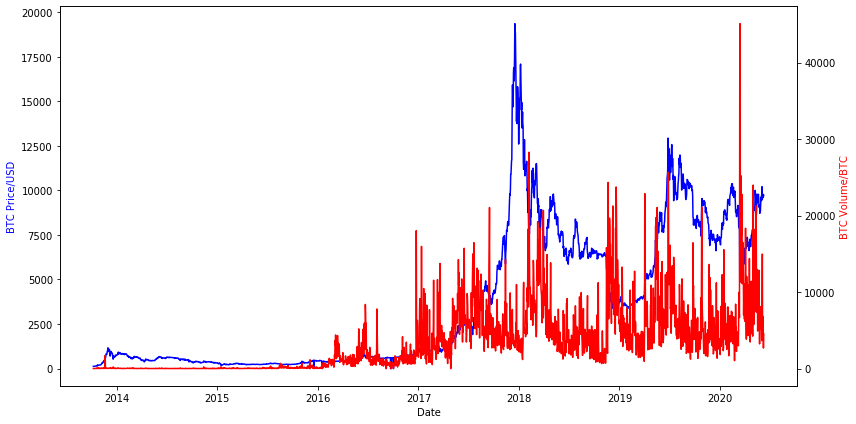

In [24]:
#pull weekly bitcoin price action and plot vs volume
df_btc_usd_kraken_1d = get_price_action(exchange="KRAKEN"
                                    ,market = "BTCUSD"
                                    ,period = '1d')
#set BTC price/time axis
fig, ax1 = plt.subplots(figsize = (12,6))
color = 'tab:blue'
ax1.set_ylabel('BTC Price/USD', color='blue')
ax1.set_xlabel('Date')
ax1.plot(df_btc_usd_kraken_1d.index
        ,df_btc_usd_kraken_1d["close"]
        ,color = 'blue')

#add second axis for volume
ax2 = ax1.twinx()

ax2.set_ylabel('BTC Volume/BTC', color='red')
ax2.plot(df_btc_usd_kraken_1d.index
         ,df_btc_usd_kraken_1d["volume"]
         ,color= 'red')
fig.tight_layout()

plt.show()


Expected result. High volume spikes align with high weekly price volatility (postitive and negative). Interesting note that at Bitcoin's highest price (~19000 USD) we see very little volume. I.e. not many traders managed to sell at the very top, most early sellers sold at ~$13000. 

<h2> Exploratory Rolling Pearson's Correlation Analysis With Index Funds</h2>

Inspired by analysis at TheBlock, I created a function to easily generate rolling correlation plots of two time series', to see if and when assets are correlated. 

The function takes two dataframes, the respective column names of interest and the specified period size. The dataframes require the highest level of granularity to be set as the dataframe index, and works best with hourly data.

In [25]:
from scipy.stats import pearsonr

#define function that takes two time series dataframes, marges them, splits into specified timeframe and 
#finds rolling correlation coefficient split by that timeframe
def cointegration_function(df1, var1, df2, var2, timeframe):
    #slice the dataframes, ensure both indexes are named same and joining to one dataframe 
    df1_slice = df1.loc[:, ['{}'.format(var1)]]
    df2_slice = df2.loc[:, ['{}'.format(var2)]]
    df1_slice.index.name = 'date'
    df2_slice.index.name = 'date'
    df_comb = pd.merge(df1_slice, df2_slice, on='date')
    #add week/month/day numbers 
    df_comb['day'] = df_comb.index.strftime('%x')
    df_comb['week'] = df_comb.index.strftime('%Y-%W')
    df_comb['month'] = df_comb.index.strftime('%Y-%m')
    
    #create empty dict for results 
    results = {}
    #split into timeframe, and calc correlation coefficient for all data points in that timeframe
    #if statement error-handles for variables that are named the same
    if var1 == var2:
        for tf in df_comb['{}'.format(timeframe)].unique():
            timeframe_data = df_comb[df_comb['{}'.format(timeframe)] == tf]
            corr = pearsonr(timeframe_data['{}'.format(var1 + '_x')], timeframe_data['{}'.format(var2 + '_y')])
            results[tf] = [corr[0]]
    else: 
  #split into timeframe, and calc correlation coefficient for all data points in that 
        for tf in df_comb['{}'.format(timeframe)].unique():
            timeframe_data = df_comb[df_comb['{}'.format(timeframe)] == tf]
            corr = pearsonr(timeframe_data['{}'.format(var1)], timeframe_data['{}'.format(var2)])
            results[tf] = [corr[0]]
    result_df = pd.DataFrame.from_dict(results, orient='index', columns=['pearsons_coeff'])
    result_df.index.name = 'timeframe'
    
    return result_df

print("Function defined sucessfully")

Function defined sucessfully


In [31]:
import yfinance as yf
from scipy.stats import pearsonr

#set tickers
tickers = {'NASDAQ' : '^IXIC'
           ,'S&P' : '^GSPC'
           ,'DOW' : '^DJI'}

#pulling in nasdaq data
nasdaq = yf.Ticker(tickers['NASDAQ'])
nasdaq_df = pd.DataFrame(nasdaq.history(period='max'))

#pulling in BTC data 
#can only get daily close data for NASDAQ
#therefore need to match with daily BTC data
btc_usd_coinbase_1d = get_price_action(exchange='COINBASE'
                                       ,market = 'BTCUSD'
                                       ,period='1d')

nasdaq_btc_monthly_corr = cointegration_function(nasdaq_df
                                                 ,'Close'
                                                 ,btc_usd_coinbase_1d
                                                 ,'close'
                                                 ,timeframe='month')

#inspect output 
nasdaq_btc_monthly_corr.head()

,pearsons_coeff
timeframe,
2015-01,0.174409
2015-02,0.603612
2015-03,-0.128183
2015-04,-0.575840
2015-05,-0.272974


Text(0.5, 0, 'Month')

Text(0, 0.5, "Pearson's Correlation Coefficient")

(735599.0, 737577.0)

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Bitcoin Price/USD & NASDAQ Points')

Text(0.5, 0, 'Date')

Text(0, 0.5, "Pearson's Correlation Coefficient")

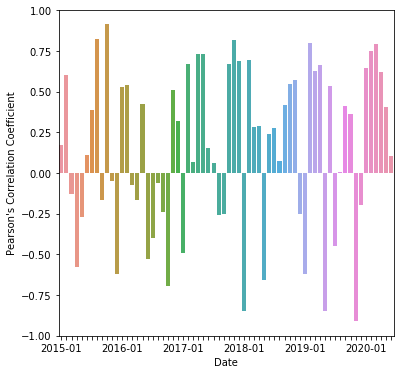

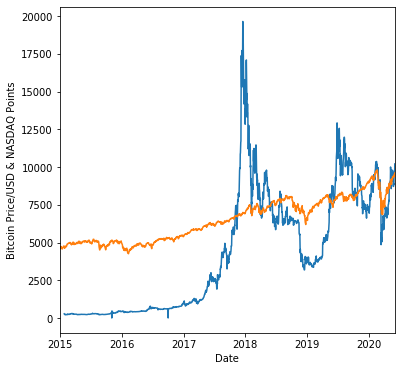

In [38]:
import seaborn as sns
from datetime import datetime, timedelta
#plot monthly correlation coefficients 
#try and merge on BTC_USD monthly to plot both on the same axis 
fig1, ax1 = plt.subplots(figsize=(6,6))

sns.barplot(x = nasdaq_btc_monthly_corr.index
                ,y = nasdaq_btc_monthly_corr['pearsons_coeff']
                ,ax =ax1)
ax1.set_xlabel("Month")
ax1.set_ylabel("Pearson's Correlation Coefficient")

#only take every 12th x label due to overlap 
for i, t in enumerate(ax1.get_xticklabels()):
    if (i % 12) != 0:
        t.set_visible(False)

#compare against price graphs 
fig2, ax2 = plt.subplots(figsize=(6,6))

sns.lineplot(x = btc_usd_coinbase_1d.index
            ,y = btc_usd_coinbase_1d['close']
            ,ax=ax2)

sns.lineplot(x = nasdaq_df.index
           ,y= nasdaq_df['Close']
           ,ax=ax2)

ax2.set_xlim([datetime(2015, 1, 1), datetime(2020, 6, 1)])
ax2.set_xlabel("Date")
ax2.set_ylabel("Bitcoin Price/USD & NASDAQ Points")

ax1.set_xlabel("Date")
ax1.set_ylabel("Pearson's Correlation Coefficient")


plt.show()

Really interesting results. We can clearly isolate time periods where both time series' correlated strongly. More recently in 2020, we see a somewhat meaningful correlation between NASDAQ and BTC. While this could have some relevancy - "retail" buyers liquidating speculative assests during COVID-19 uncertainty/crash and subsequently rebuying at supposed NASDAQ bounce - we must be VERY careful in drawing any sort of actionable conclusions. It is an interseting observation NOT intended to support any financial decision, but the function used to draw this insight is applicable in many other points of view.